In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline as SkPipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, f1_score, recall_score, make_scorer, precision_score
from sklearn.inspection import permutation_importance
from collections import defaultdict
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import GaussianNB


# Data Pre-processing

In [58]:
import pandas as pd

df =pd.read_excel(r"C:\Users\cpim1\Downloads\MLB_2021-24_ML.xlsx")

df.drop(['RowNum', 'Team', 'Rk', 'Lg', 'Year'], axis=1, inplace=True)

df.head(10)


,Player,Age,WAR,G,PA,AB,R,H,2B,3B,...,OPS+,rOBA,Rbat+,TB,GIDP,HBP,SH,SF,IBB,AS
0,AJ Pollock,35,-0.7,54,144,133,15,22,4,0,...,47,0.233,48,41,1,0,0,2,0,0
1,Aaron Hicks#,33,0.5,93,312,269,44,68,9,1,...,106,0.328,106,103,3,0,0,1,1,0
2,Abraham Toro#,24,1.5,95,375,335,45,80,12,0,...,92,0.311,97,125,5,7,0,2,0,0
3,Adam Duvall,32,2.9,146,555,513,67,117,17,2,...,102,0.333,100,252,7,4,0,3,1,0
4,Adam Eaton*,32,-0.4,83,288,254,38,51,10,2,...,66,0.271,61,83,6,7,4,1,0,0
5,Adam Frazier*,29,4.0,155,639,577,83,176,36,5,...,114,0.342,113,237,10,10,3,1,2,1
6,Albert Pujols,41,-0.6,109,296,275,29,65,3,0,...,89,0.305,80,119,14,5,0,2,3,0
7,Alex Call,27,0.4,47,131,114,18,27,3,1,...,115,0.325,115,47,2,2,0,0,0,0
8,Alex Jackson,25,-0.5,52,151,131,13,18,4,0,...,33,0.235,33,31,0,7,0,0,1,0
9,Alfonso Rivas III*,26,0.3,48,123,109,8,25,10,1,...,95,0.313,90,46,1,3,1,1,0,0


In [59]:
df.columns

Index(['Player', 'Age', 'WAR', 'G', 'PA', 'AB', 'R', 'H', '2B', '3B', 'HR',
       'RBI', 'SB', 'CS', 'BB', 'SO', 'BA', 'OBP', 'SLG', 'OPS', 'OPS+',
       'rOBA', 'Rbat+', 'TB', 'GIDP', 'HBP', 'SH', 'SF', 'IBB', 'AS'],
      dtype='object')

In [60]:
# feature columns 
# feature_columns = ['Age', 'WAR', 'G', 'PA', 'AB', 'R', 'H', '2B', '3B', 'HR',
#        'RBI', 'SB', 'CS', 'BB', 'SO', 'BA', 'OBP', 'SLG', 'OPS', 'OPS+',
#        'rOBA', 'Rbat+', 'TB', 'GIDP', 'HBP', 'SH', 'SF', 'IBB']

feature_columns = ['WAR', 'G', 'PA', 'AB', 'R', 'H', '2B', '3B', 'HR',
       'RBI', 'SB', 'CS', 'BB', 'SO', 'BA', 'OBP', 'SLG', 'OPS',
       'TB', 'HBP', 'SH', 'SF', 'IBB']


# target column
target_col = 'AS'

In [61]:
# Values of Non All Stars (0) and All Stars (1)
print(df['AS'].value_counts())



AS
0    1730
1     190
Name: count, dtype: int64


Features, Targets, and Splitting Data

In [62]:
#Features and Targets 
X = df[feature_columns]
y = df[target_col]

print('\033[1mClass Proportions:\033[0m')
print(y.value_counts(normalize=True).round(2))

#Split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify = y)

Class Proportions:
AS
0    0.9
1    0.1
Name: proportion, dtype: float64


## Make the BETA2 value

In [63]:
import numpy as np
from sklearn.metrics import fbeta_score, make_scorer

# ---- BETA2 setup (≈ 70% recall, 30% precision) ----
BETA2_RECALL_WEIGHT = 0.6
BETA2_PRECISION_WEIGHT = 0.4
BETA2_VALUE = np.sqrt(BETA2_RECALL_WEIGHT / BETA2_PRECISION_WEIGHT)  # ≈ 1.53

def make_beta2_scorer(pos_label=1):
    """
    Return:
      - scorer: for GridSearchCV(scoring=...)
      - beta:   numeric beta value used (BETA2_VALUE)
    """
    scorer = make_scorer(
        fbeta_score,
        beta=BETA2_VALUE,
        pos_label=pos_label
    )
    return scorer, BETA2_VALUE

def beta2_score(y_true, y_pred, pos_label=1):
    """
    Convenience function to compute the BETA2 score on predictions.
    """
    return fbeta_score(
        y_true,
        y_pred,
        beta=BETA2_VALUE,
        pos_label=pos_label
    )


def find_best_threshold_fbeta(y_true, y_proba, beta=BETA2_VALUE, pos_label=1, thresholds=None):
    if thresholds is None:
        thresholds = np.arange(0.25, 1.01, 0.05)
    
    best_threshold = None
    best_score = -np.inf
    scores = []

    for t in thresholds:
        y_pred = (y_proba >= t).astype(int)
        score = fbeta_score(
            y_true,
            y_pred,
            beta=beta,
            pos_label=pos_label,
            zero_division=0
        )
        scores.append(score)
        if score > best_score:
            best_score = score
            best_threshold = t

    return best_threshold, best_score, np.array(thresholds), np.array(scores)

# Logistic Regression
**Three models to include:**

**1. Logistic Regression Benchmark**<br>
f1 = 0.64<br>
recall = 0.51

**2. Regularization**<br>
Best threshold for F1: 0.45<br>
f1 = 0.69<br>
recall = 0.63

**3. SMOTE + Optimal ratio**<br>
Best threshold for F1= 0.63<br>
f1 = 0.67<br>
recall = 0.65



## Benchmark

Classification Report:
               precision    recall  f1-score   support

      Non-AS       0.95      0.98      0.96       519
          AS       0.73      0.53      0.61        57

    accuracy                           0.93       576
   macro avg       0.84      0.75      0.79       576
weighted avg       0.93      0.93      0.93       576


Confusion Matrix:
 [[508  11]
 [ 27  30]]

AUC: 0.7525605922320251


c:\Users\cpim1\WindSurf_School\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


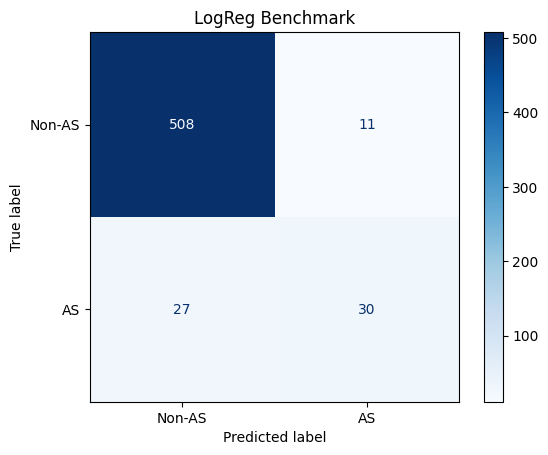

In [64]:
#logistic regression no scaling (for benchmark)
log_reg_benchmark = LogisticRegression()
log_reg_benchmark.fit(X_train, y_train)
y_pred = log_reg_benchmark.predict(X_test)

#print classification report  and AUC and confusion matrix
print('Classification Report:\n', classification_report(y_test, y_pred, target_names = ['Non-AS', 'AS']))
print('\nConfusion Matrix:\n', confusion_matrix(y_test, y_pred))
print("\nAUC:", roc_auc_score(y_test, y_pred))

#add label to the confusion matrix (Logistic Regression Benchmark)

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['Non-AS', 'AS'])
disp.plot(cmap='Blues')
plt.title("LogReg Benchmark")
plt.show()

## Regularization

beta2_value: 1.224744871391589
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters: {'logreg__C': 100, 'logreg__class_weight': None, 'logreg__penalty': 'l1'}
Best F1.224744871391589 score (cv mean): 0.5910
Best threshold (F1.224744871391589): 0.42
Best F1.224744871391589 score:      0.6604
Precision at best threshold: 0.7447
Recall at best threshold:    0.6140

Confusion matrix at best threshold:
[[507  12]
 [ 22  35]]

Classification report at best threshold:
              precision    recall  f1-score   support

           0     0.9584    0.9769    0.9676       519
           1     0.7447    0.6140    0.6731        57

    accuracy                         0.9410       576
   macro avg     0.8515    0.7955    0.8203       576
weighted avg     0.9373    0.9410    0.9384       576

Best BETA2 score:, 0.5910


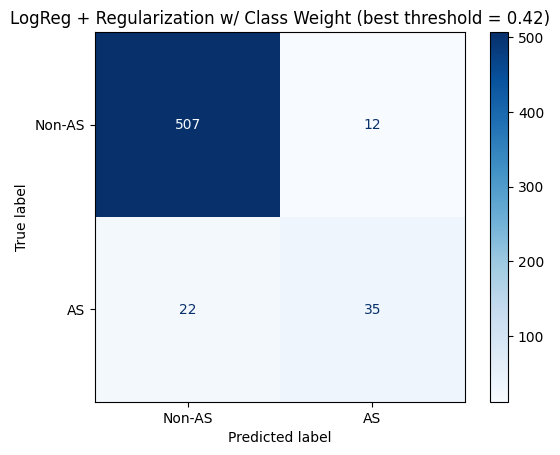

In [65]:
#initiate pipeline
logreg_pipeline = SkPipeline(steps=[
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(
        max_iter=1000,
        random_state=42,
        solver = 'liblinear' #different solver to allow L1 and L2
    ))
])

#parameters
param_grid_logreg = {
    'logreg__C': [0.001, 0.01, 0.1, 1, 10, 100], # regularization strength
    'logreg__penalty': ['l1', 'l2'], #regularization type
    'logreg__class_weight': [None, 'balanced'] #class weight
}

#cross validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#BETA2
beta2_scorer, beta2_value = make_beta2_scorer(pos_label=1)
print('beta2_value:',beta2_value)
#GridSearchCV
logreg_grid = GridSearchCV(
    estimator = logreg_pipeline ,
    param_grid = param_grid_logreg, 
    cv=cv,
    scoring=beta2_scorer,
    n_jobs=-1,
    verbose=1 
)

#fit the data
logreg_grid.fit(X_train, y_train)

#print best parameters and f1 score
print("Best parameters:", logreg_grid.best_params_)
print(f"Best F{beta2_value} score (cv mean): {logreg_grid.best_score_:.4f}")

best_model_l1l2 = logreg_grid.best_estimator_ # grid_logreg.best_estimator_ is the logreg pipeline trained with the best parameters

y_proba = best_model_l1l2.predict_proba(X_test)[:, 1]

best_threshold, best_fbeta, thr_array, fbeta_array = find_best_threshold_fbeta(
    y_true=y_test,
    y_proba=y_proba,
    beta=beta2_value,   # from make_beta2_scorer
    pos_label=1,
    thresholds=np.arange(0.25, 1.01, 0.01)
)

print(f"Best threshold (F{beta2_value}): {best_threshold:.2f}")
print(f"Best F{beta2_value} score:      {best_fbeta:.4f}")

# 4. Evaluate at this best threshold
y_pred_opt = (y_proba >= best_threshold).astype(int)

prec = precision_score(y_test, y_pred_opt, pos_label=1, zero_division=0)
rec = recall_score(y_test, y_pred_opt, pos_label=1, zero_division=0)

print(f"Precision at best threshold: {prec:.4f}")
print(f"Recall at best threshold:    {rec:.4f}")

print("\nConfusion matrix at best threshold:")
print(confusion_matrix(y_test, y_pred_opt))

print("\nClassification report at best threshold:")
print(classification_report(y_test, y_pred_opt, digits=4))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_opt, display_labels=["Non-AS", "AS"], cmap="Blues")
plt.title(f"LogReg + Regularization w/ Class Weight (best threshold = {best_threshold:.2f})")
print(f'Best BETA2 score:, {logreg_grid.best_score_:.4f}')

## SMOTE + Optimal ratio

Fitting 5 folds for each of 120 candidates, totalling 600 fits


c:\Users\cpim1\WindSurf_School\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
60 fits failed out of a total of 600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\cpim1\WindSurf_School\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\cpim1\WindSurf_School\.venv\Lib\site-packages\sklearn\base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\cpim1\WindSurf_School\.venv\Lib\site-packages\imblearn\pipeline.p

Best parameters: {'logreg__C': 1, 'logreg__penalty': 'l2', 'smote__sampling_strategy': 0.3}
Best F1.224744871391589 score (CV mean): 0.6480

Best threshold for F1.224744871391589: 0.33
Best F1.224744871391589 at that threshold: 0.6628

Classification Report at Best Threshold:

              precision    recall  f1-score   support

       No AS       0.98      0.92      0.95       519
          AS       0.52      0.81      0.63        57

    accuracy                           0.91       576
   macro avg       0.75      0.86      0.79       576
weighted avg       0.93      0.91      0.92       576


Confusion Matrix at Best Threshold:
[[477  42]
 [ 11  46]]
Best BETA2 score:, 0.6480


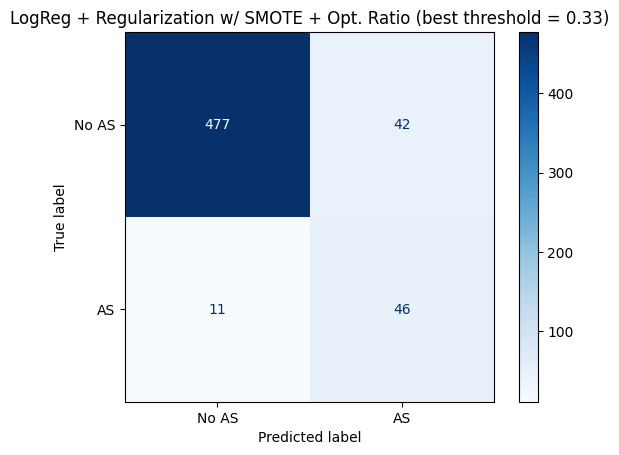

In [66]:
#initiate pipeline
logreg_pipeline = ImbPipeline(steps=[
    ('smote', SMOTE(random_state=42)),  # handles class imalance on the training folds only
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(
        max_iter=1000,
        random_state=42,
        solver = 'liblinear' #different solver to allow L1 and L2
    ))
])

#parameters
param_grid_logreg = {
    'smote__sampling_strategy': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], # SMOTE ratios to try: keep them reasonable
    'logreg__C': [0.001, 0.01, 0.1, 1, 10, 100], # regularization strength
    'logreg__penalty': ['l1', 'l2'], #regularization type
}

#cross validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

beta2_scorer, beta2_value = make_beta2_scorer(pos_label=1)

#GridSearchCV
logreg_grid = GridSearchCV(
    estimator=logreg_pipeline,
    param_grid=param_grid_logreg,
    cv=cv,
    scoring=beta2_scorer,     # <<--- now using beta2 scorer
    n_jobs=-1,
    verbose=1
)

#fit the data
logreg_grid.fit(X_train, y_train)

#print best parameters and f1 score
print("Best parameters:", logreg_grid.best_params_)
print(f"Best F{beta2_value} score (CV mean): {logreg_grid.best_score_:.4f}")

best_model_opt_smote = logreg_grid.best_estimator_
y_proba_test_smote_optimal = best_model_opt_smote.predict_proba(X_test)[:, 1]

best_threshold, best_fbeta, thr_array, fbeta_array = find_best_threshold_fbeta(
    y_true=y_test,
    y_proba=y_proba_test_smote_optimal,
    beta=beta2_value,
    pos_label=1,
    thresholds=np.arange(0.0, 1.01, 0.01)
)

print(f"\nBest threshold for F{beta2_value}: {best_threshold:.2f}")
print(f"Best F{beta2_value} at that threshold: {best_fbeta:.4f}")

# 8. Evaluate at the best threshold
# -----------------------------
y_pred_best = (y_proba_test_smote_optimal >= best_threshold).astype(int)

print("\nClassification Report at Best Threshold:\n")
print(classification_report(y_test, y_pred_best, target_names=['No AS', 'AS']))

print("\nConfusion Matrix at Best Threshold:")
cm_best = confusion_matrix(y_test, y_pred_best)
print(cm_best)


# 9. Plot Confusion Matrix
# -----------------------------
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred_best,
    display_labels=["No AS", "AS"],
    cmap="Blues"
)
plt.title(f"LogReg + Regularization w/ SMOTE + Opt. Ratio (best threshold = {best_threshold:.2f})")
print(f'Best BETA2 score:, {logreg_grid.best_score_:.4f}')
plt.show()

In [81]:
# Extract the SMOTE step from the best model
smote_step = best_model_opt_smote.named_steps['smote']

# Apply SMOTE to the training data
X_res, y_res = smote_step.fit_resample(X_train, y_train)

# Check class proportions after SMOTE
import numpy as np
classes, counts = np.unique(y_res, return_counts=True)

print("Class proportions AFTER SMOTE:")
for c, ct in zip(classes, counts):
    print(f"Class {c}: {ct} ({ct/len(y_res):.2%})")

Class proportions AFTER SMOTE:
Class 0: 1211 (76.94%)
Class 1: 363 (23.06%)


## ROC Curves

In [67]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# 1) Get predicted probabilities for the positive class (AS = 1)
y_proba_l1          = best_model_l1.predict_proba(X_test)[:, 1]
y_proba_l1l2        = best_model_l1l2.predict_proba(X_test)[:, 1]
y_proba_smote       = best_model_smote.predict_proba(X_test)[:, 1]
y_proba_opt_smote   = best_model_opt_smote.predict_proba(X_test)[:, 1]

# 2) Compute ROC curve points
fpr_l1,        tpr_l1,        _ = roc_curve(y_test, y_proba_l1)
fpr_l1l2,      tpr_l1l2,      _ = roc_curve(y_test, y_proba_l1l2)
fpr_smote,     tpr_smote,     _ = roc_curve(y_test, y_proba_smote)
fpr_opt_smote, tpr_opt_smote, _ = roc_curve(y_test, y_proba_opt_smote)

# 3) Compute AUCs
auc_l1        = roc_auc_score(y_test, y_proba_l1)
auc_l1l2      = roc_auc_score(y_test, y_proba_l1l2)
auc_smote     = roc_auc_score(y_test, y_proba_smote)
auc_opt_smote = roc_auc_score(y_test, y_proba_opt_smote)

print(f"L1 model AUC:             {auc_l1:.3f}")
print(f"L1+L2 model AUC:          {auc_l1l2:.3f}")
print(f"SMOTE model AUC:          {auc_smote:.3f}")
print(f"Optimized SMOTE AUC:      {auc_opt_smote:.3f}")

# 4) Plot all ROC curves together
plt.figure(figsize=(8, 6))

plt.plot(fpr_l1,        tpr_l1,        label=f'L1 (AUC = {auc_l1:.3f})')
plt.plot(fpr_l1l2,      tpr_l1l2,      label=f'L1+L2 (AUC = {auc_l1l2:.3f})')
plt.plot(fpr_smote,     tpr_smote,     label=f'SMOTE (AUC = {auc_smote:.3f})')
plt.plot(fpr_opt_smote, tpr_opt_smote, label=f'Opt SMOTE (AUC = {auc_opt_smote:.3f})')

# Random baseline
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve – Logistic Regression Model Comparison')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


NameError: name 'best_model_l1' is not defined

Recap: 

Log Reg BenchMark F1 score: .62

L1 F1 score: .67

L2 F1 score: .69

SMOTE F1 score: .60

SMOTE w optimal ratio F1 score: .65

# Decision Tree

**Three models to include:**

**1. Decision Tree Benchmark**<br>
f1 = 0.55<br>
recall = 0.58

**2. Pre-pruning**<br>
Best threshold for F1: 0.17<br>
f1 = 0.59<br>
recall = 0.67

**3. Post Pruning for Decision Tree using CCP**<br>
Best threshold for F1= 0.14<br>
f1 = 0.62<br>
recall = 0.74

##  Decision Tree Benchmark

In [ ]:
dectree_benchmark = DecisionTreeClassifier(random_state=42)
dectree_benchmark.fit(X_train, y_train)
dectree_benchmark.score(X_test, y_test)

#Print Confusion Matrix and Classification Report
print("Confusion Matrix")
print(confusion_matrix(y_test, dectree_benchmark.predict(X_test)))
print("\nClassification Report for Decision Tree Benchmark: ")
print(classification_report(y_test, dectree_benchmark.predict(X_test)))

Confusion Matrix
[[492  27]
 [ 29  28]]

Classification Report for Decision Tree Benchmark: 
              precision    recall  f1-score   support

           0       0.94      0.95      0.95       519
           1       0.51      0.49      0.50        57

    accuracy                           0.90       576
   macro avg       0.73      0.72      0.72       576
weighted avg       0.90      0.90      0.90       576



## Pre-pruning

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best Parameters (pre-pruned tree): {'tree__class_weight': 'balanced', 'tree__criterion': 'gini', 'tree__max_depth': None, 'tree__min_samples_leaf': 4, 'tree__min_samples_split': 2}
Best CV F1.224744871391589 (pre-pruned tree): 0.4952

Best threshold for Decision Tree (F1.224744871391589): 0.86
Best F1.224744871391589 at that threshold: 0.6184

Classification Report at Best Threshold:

              precision    recall  f1-score   support

       No AS       0.96      0.96      0.96       519
          AS       0.62      0.61      0.62        57

    accuracy                           0.93       576
   macro avg       0.79      0.79      0.79       576
weighted avg       0.92      0.93      0.93       576


Confusion Matrix at Best Threshold:
[[498  21]
 [ 22  35]]
Best BETA2 score:, 0.4952


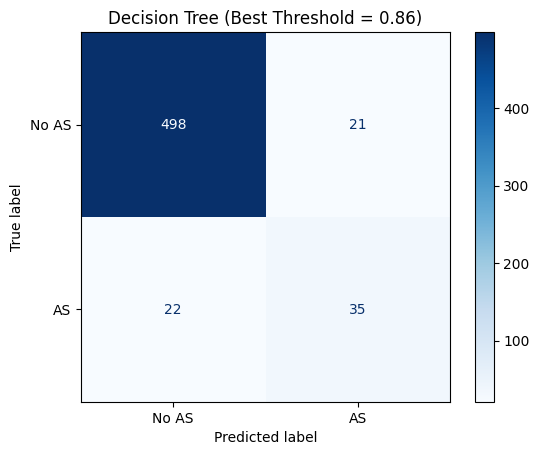

In [ ]:
# Initialize the pipeline
dectree_pipeline = SkPipeline(steps=[
    ('scaler', StandardScaler()),
    ('tree', DecisionTreeClassifier(random_state=42))   # match the base tree
])

#Pre-Pruning Parameters
dectree_param_grid = {
    'tree__max_depth': [None, 10, 20, 30],
    'tree__min_samples_split': [2, 5, 10],
    'tree__min_samples_leaf': [1, 2, 4],
    'tree__criterion': ['gini', 'entropy', 'log_loss'],
    'tree__class_weight': ['balanced', None]
}

#Cross Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

beta2_scorer, beta2_value = make_beta2_scorer(pos_label=1)

dectree_grid = GridSearchCV(
    estimator=dectree_pipeline,
    param_grid=dectree_param_grid,
    cv=cv,
    scoring=beta2_scorer,   # <<--- changed from 'f1'
    n_jobs=-1,
    verbose=1
)

# Fit the model
dectree_grid.fit(X_train, y_train)

# Display the best params
print(f'Best Parameters (pre-pruned tree): {dectree_grid.best_params_}')
print(f'Best CV F{beta2_value} (pre-pruned tree): {dectree_grid.best_score_:.4f}')

# Best model
tree_pre_model = dectree_grid.best_estimator_

# ----------------------------------------
# 2) Predict probabilities on test set
# ----------------------------------------
y_proba_tree = tree_pre_model.predict_proba(X_test)[:, 1]

# ----------------------------------------
# 3) Find best threshold using F-beta helper
# ----------------------------------------
best_threshold_tree, best_fbeta_tree, thr_array_tree, fbeta_array_tree = find_best_threshold_fbeta(
    y_true=y_test,
    y_proba=y_proba_tree,
    beta=beta2_value,
    pos_label=1,
    thresholds=np.arange(0.0, 1.01, 0.01)
)

print(f"\nBest threshold for Decision Tree (F{beta2_value}): {best_threshold_tree:.2f}")
print(f"Best F{beta2_value} at that threshold: {best_fbeta_tree:.4f}")

# ----------------------------------------
# 4) Evaluate model at the best threshold
# ----------------------------------------
y_pred_tree_best = (y_proba_tree >= best_threshold_tree).astype(int)

print("\nClassification Report at Best Threshold:\n")
print(classification_report(y_test, y_pred_tree_best, target_names=['No AS', 'AS']))

print("\nConfusion Matrix at Best Threshold:")
cm_best = confusion_matrix(y_test, y_pred_tree_best)
print(cm_best)

# ----------------------------------------
# 5) Plot confusion matrix
# ----------------------------------------
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred_tree_best,
    display_labels=['No AS', 'AS'],
    cmap='Blues'
)
plt.title(f"Decision Tree (Best Threshold = {best_threshold_tree:.2f})")
print(f'Best BETA2 score:, {dectree_grid.best_score_:.4f}')
plt.show()

## Post Pruning for Decision Tree using CCP

Number of candidate alphas: 43
Fitting 5 folds for each of 9288 candidates, totalling 46440 fits
Best Parameters (post-pruned tree): {'tree__ccp_alpha': np.float64(0.007571911746625762), 'tree__class_weight': None, 'tree__criterion': 'entropy', 'tree__max_depth': None, 'tree__min_samples_leaf': 2, 'tree__min_samples_split': 2}
Best CV F1.224744871391589 (post-pruned tree): 0.5430

Best threshold for Post-Pruned Tree (F1.224744871391589): 0.25
Best F1.224744871391589 at that threshold: 0.6304

Classification Report at Best Threshold:

              precision    recall  f1-score   support

       No AS       0.97      0.91      0.94       519
          AS       0.49      0.77      0.60        57

    accuracy                           0.90       576
   macro avg       0.73      0.84      0.77       576
weighted avg       0.93      0.90      0.91       576


Confusion Matrix at Best Threshold:
[[474  45]
 [ 13  44]]
Best BETA2 score:, 0.5430


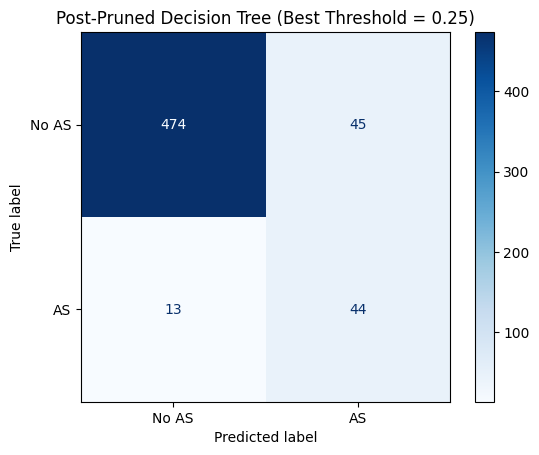

In [ ]:

# ------------------------------------------------------
# 1) Get candidate ccp_alpha values from an unpruned tree
# ------------------------------------------------------

path = dectree_benchmark.cost_complexity_pruning_path(X_train, y_train) # cost_complexity_pruning_path returns a list of ccp_alphas
ccp_alphas = path.ccp_alphas[:-1]   # drop last alpha (would prune to single node)

print(f"Number of candidate alphas: {len(ccp_alphas)}") 

# ------------------------------------------------------
# 2) Post-pruning Decision Tree with Pipeline + GridSearchCV
# ------------------------------------------------------
dectree_post_pipeline = SkPipeline(steps=[
    ('scaler', StandardScaler()),
    ('tree', DecisionTreeClassifier(
        random_state=42
    ))
])

# Only tuning ccp_alpha now (post-pruning) #In post pruning, only looking for the best ccp_alpha value
dectree_post_param_grid = {
    'tree__max_depth': [None, 10, 20, 30],
    'tree__min_samples_split': [2, 5, 10],
    'tree__min_samples_leaf': [1, 2, 4],
    'tree__criterion': ['gini', 'entropy', 'log_loss'],
    'tree__ccp_alpha': ccp_alphas,
    'tree__class_weight': [None, 'balanced']
}

# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

beta2_scorer, beta2_value = make_beta2_scorer(pos_label=1)

# Grid Search
dectree_post_grid = GridSearchCV(
    estimator=dectree_post_pipeline,
    param_grid=dectree_post_param_grid,
    cv=cv,
    scoring=beta2_scorer,   # <<--- changed from 'f1' to F-beta scorer
    n_jobs=-1,
    verbose=1
)

dectree_post_grid.fit(X_train, y_train)

print(f"Best Parameters (post-pruned tree): {dectree_post_grid.best_params_}")
print(f"Best CV F{beta2_value} (post-pruned tree): {dectree_post_grid.best_score_:.4f}")

# Best estimator
tree_post_model = dectree_post_grid.best_estimator_

# ------------------------------------------------------
# 3) Predict probabilities on test set
# ------------------------------------------------------
y_proba_post = tree_post_model.predict_proba(X_test)[:, 1]

# ------------------------------------------------------
# 4) Find best threshold using your F-beta function
# ------------------------------------------------------
best_threshold_post, best_fbeta_post, thr_array_post, fbeta_array_post = find_best_threshold_fbeta(
    y_true=y_test,
    y_proba=y_proba_post,
    beta=beta2_value,
    pos_label=1,
    thresholds=np.arange(0.25, 1.01, 0.01)
)

print(f"\nBest threshold for Post-Pruned Tree (F{beta2_value}): {best_threshold_post:.2f}")
print(f"Best F{beta2_value} at that threshold: {best_fbeta_post:.4f}")

# ------------------------------------------------------
# 5) Evaluate at best threshold
# ------------------------------------------------------
y_pred_post_best = (y_proba_post >= best_threshold_post).astype(int)

print("\nClassification Report at Best Threshold:\n")
print(classification_report(y_test, y_pred_post_best, target_names=['No AS', 'AS']))

print("\nConfusion Matrix at Best Threshold:")
cm_post_best = confusion_matrix(y_test, y_pred_post_best)
print(cm_post_best)

# ------------------------------------------------------
# 6) Plot confusion matrix
# ------------------------------------------------------
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred_post_best,
    display_labels=['No AS', 'AS'],
    cmap='Blues'
)
plt.title(f"Post-Pruned Decision Tree (Best Threshold = {best_threshold_post:.2f})")
print(f'Best BETA2 score:, {dectree_post_grid.best_score_:.4f}')

plt.show()

## ROC Curve

Pre-pruned tree AUC:     0.846
Post-pruned tree AUC:    0.896
Benchmark tree AUC:      0.720


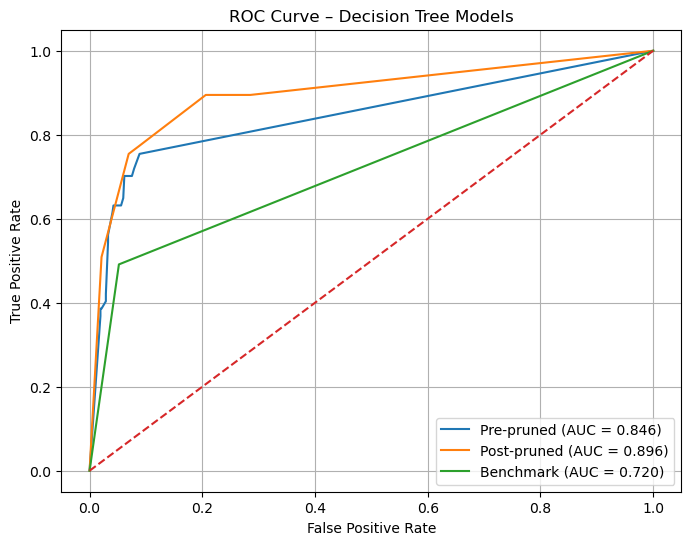

In [ ]:
# 1) Get predicted probabilities for positive class (label 1)
y_proba_bench = dectree_benchmark.predict_proba(X_test)[:, 1]
y_proba_pre   = tree_pre_model.predict_proba(X_test)[:, 1]
y_proba_post  = tree_post_model.predict_proba(X_test)[:, 1]

# 2) Compute ROC curve points
fpr_bench, tpr_bench, _ = roc_curve(y_test, y_proba_bench)
fpr_pre,   tpr_pre,   _ = roc_curve(y_test, y_proba_pre)
fpr_post,  tpr_post,  _ = roc_curve(y_test, y_proba_post)

# 3) Compute AUCs
auc_pre   = roc_auc_score(y_test, y_proba_pre)
auc_post  = roc_auc_score(y_test, y_proba_post)
auc_bench = roc_auc_score(y_test, y_proba_bench)

print(f"Pre-pruned tree AUC:     {auc_pre:.3f}")
print(f"Post-pruned tree AUC:    {auc_post:.3f}")
print(f"Benchmark tree AUC:      {auc_bench:.3f}")

# 4) Plot ROC curves together
plt.figure(figsize=(8, 6))

plt.plot(fpr_pre,   tpr_pre,   label=f'Pre-pruned (AUC = {auc_pre:.3f})')
plt.plot(fpr_post,  tpr_post,  label=f'Post-pruned (AUC = {auc_post:.3f})')
plt.plot(fpr_bench, tpr_bench, label=f'Benchmark (AUC = {auc_bench:.3f})')

# Random baseline
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve – Decision Tree Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Random Forest

**Two models to include:**

**1. Random Forest Benchmark**<br>
f1 = 0.57<br>
recall = 0.46

**2. Random Forest with tuning**<br>
Best threshold for F1: 0.44<br>
f1 = 0.65<br>
recall = 0.60

## Random Forest Benchmark

In [ ]:
# Random forest benchmark
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print('\nClassification Report for RF Benchmark: ')
print(classification_report(y_test, y_pred))    
print('\n Confusion Matrix for RF Benchmark: ')
print(confusion_matrix(y_test, y_pred))


Classification Report for RF Benchmark: 
              precision    recall  f1-score   support

           0       0.94      0.99      0.97       519
           1       0.82      0.47      0.60        57

    accuracy                           0.94       576
   macro avg       0.88      0.73      0.78       576
weighted avg       0.93      0.94      0.93       576


 Confusion Matrix for RF Benchmark: 
[[513   6]
 [ 30  27]]


## Random Forest with tuning

In [ ]:
#Random Forest

#Initialize the pipeline
pipe_rf = SkPipeline(steps=[
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(random_state=42, n_jobs = -1))
])

#Parameter grid
rf_param_grid = {
    'rf__n_estimators': [100, 200, 300],
    'rf__max_depth': [None, 10, 20, 30],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4],
    'rf__max_features': [None, 'sqrt', 'log2'],
    'rf__bootstrap': [True, False]
}

#Cross Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
beta2_scorer, beta2_value = make_beta2_scorer(pos_label=1)

# Grid Search with F-beta
grid_rf = GridSearchCV(
    estimator=pipe_rf,
    param_grid=rf_param_grid,
    cv=cv,
    scoring=beta2_scorer,   # <<--- changed from 'f1'
    n_jobs=-1,
    verbose=1
)

# Fit the grid search
grid_rf.fit(X_train, y_train)

print(f'Best Random Forest Parameters: {grid_rf.best_params_}')
print(f'Best Random Forest CV F{beta2_value} Score: {grid_rf.best_score_:.4f}')


Fitting 5 folds for each of 648 candidates, totalling 3240 fits
Best Random Forest Parameters: {'rf__bootstrap': True, 'rf__max_depth': None, 'rf__max_features': None, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 10, 'rf__n_estimators': 100}
Best Random Forest CV F1.224744871391589 Score: 0.5503



Best threshold for Random Forest (F1.224744871391589): 0.25
Best F1.224744871391589 at that threshold: 0.6462

Classification Report at Best Threshold:

              precision    recall  f1-score   support

       No AS       0.97      0.93      0.95       519
          AS       0.55      0.74      0.63        57

    accuracy                           0.91       576
   macro avg       0.76      0.83      0.79       576
weighted avg       0.93      0.91      0.92       576


Confusion Matrix at Best Threshold:
[[484  35]
 [ 15  42]]
Best Random Forest BETA2 1.224744871391589 Score: 0.5503


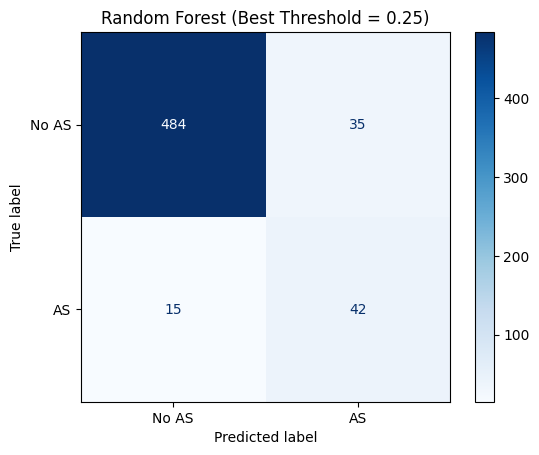

In [ ]:
best_rf = grid_rf.best_estimator_
y_proba_rf = best_rf.predict_proba(X_test)[:, 1]


best_threshold_rf, best_fbeta_rf, thr_array_rf, fbeta_array_rf = find_best_threshold_fbeta(
    y_true=y_test,
    y_proba=y_proba_rf,
    beta=beta2_value,
    pos_label=1,
    thresholds=np.arange(0.25, 1.01, 0.01)
)

print(f"\nBest threshold for Random Forest (F{beta2_value}): {best_threshold_rf:.2f}")
print(f"Best F{beta2_value} at that threshold: {best_fbeta_rf:.4f}")

y_pred_rf_best = (y_proba_rf >= best_threshold_rf).astype(int)

print("\nClassification Report at Best Threshold:\n")
print(classification_report(y_test, y_pred_rf_best, target_names=['No AS', 'AS']))

print("\nConfusion Matrix at Best Threshold:")
cm_rf_best = confusion_matrix(y_test, y_pred_rf_best)
print(cm_rf_best)

ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred_rf_best,
    display_labels=['No AS', 'AS'],
    cmap='Blues'
)
plt.title(f"Random Forest (Best Threshold = {best_threshold_rf:.2f})")
print(f'Best Random Forest BETA2 {beta2_value} Score: {grid_rf.best_score_:.4f}')

plt.show()

# Naive Bayes

**Two models to include:**

**1. Naive Bayes Benchmark**<br>
f1 = 0.55<br>
recall = 0.88

**2. Gaussian Naive Bayes (Calculated Priors)**<br>
Best threshold for F1: 0.98<br>
f1 = 0.59<br>
recall = 0.86

## Naive Bayes Benchmark

In [ ]:
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

y_pred_nb = nb_model.predict(X_test)
print("\n=== Classification Report: Naive Bayes Benchmark ===\n")
print(classification_report(y_test, y_pred_nb, target_names=['No AS', 'AS']))

print("\n=== Confusion Matrix: Naive Bayes Benchmark ===\n")
print(confusion_matrix(y_test, y_pred_nb))


=== Classification Report: Naive Bayes Benchmark ===

              precision    recall  f1-score   support

       No AS       0.98      0.85      0.91       519
          AS       0.39      0.88      0.54        57

    accuracy                           0.85       576
   macro avg       0.69      0.86      0.73       576
weighted avg       0.93      0.85      0.88       576


=== Confusion Matrix: Naive Bayes Benchmark ===

[[441  78]
 [  7  50]]


## Gaussian Naive Bayes (Calculated Priors)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
Best Parameters (Naive Bayes with priors): {'nb__var_smoothing': np.float64(1e-08)}
Best CV F1.224744871391589 (Naive Bayes with priors):     0.5377

Best threshold for Naive Bayes (F1.224744871391589): 0.92
Best F1.224744871391589 at that threshold: 0.6083

Classification Report at Best Threshold:

              precision    recall  f1-score   support

       No AS       0.98      0.87      0.92       519
          AS       0.42      0.88      0.56        57

    accuracy                           0.87       576
   macro avg       0.70      0.87      0.74       576
weighted avg       0.93      0.87      0.89       576


Confusion Matrix at Best Threshold:
[[449  70]
 [  7  50]]
Best Naive Bayes BETA2 1.224744871391589 Score: 0.5377


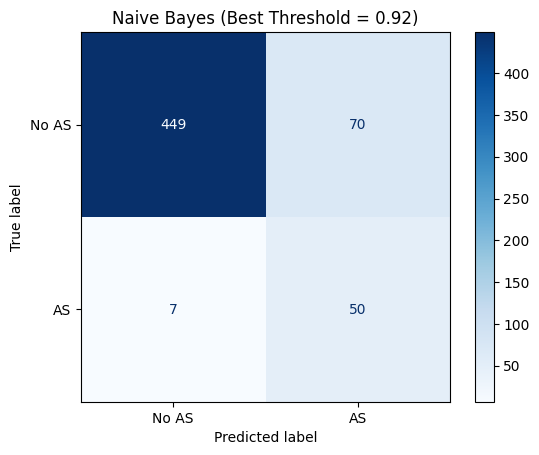

In [72]:

classes, counts = np.unique(y_train, return_counts=True)
priors = counts / counts.sum()
nb_pipeline = SkPipeline(steps=[
    ('nb', GaussianNB(priors=priors))
])
nb_param_grid = {'nb__var_smoothing': np.logspace(-12, -6, 7)}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
beta2_scorer, beta2_value = make_beta2_scorer(pos_label=1)

nb_grid = GridSearchCV(
    estimator=nb_pipeline,
    param_grid=nb_param_grid,
    cv=cv,
    scoring=beta2_scorer,    # <<--- changed from 'f1'
    n_jobs=-1,
    verbose=1
)
nb_grid.fit(X_train, y_train)

print("Best Parameters (Naive Bayes with priors):", nb_grid.best_params_)
print(f"Best CV F{beta2_value} (Naive Bayes with priors):     {nb_grid.best_score_:.4f}")

best_nb_priors = nb_grid.best_estimator_
y_proba_nb = best_nb_priors.predict_proba(X_test)[:, 1]

best_threshold_nb, best_fbeta_nb, thr_array_nb, fbeta_array_nb = find_best_threshold_fbeta(
    y_true=y_test,
    y_proba=y_proba_nb,
    beta=beta2_value,
    pos_label=1,
    thresholds=np.arange(0.0, 1.01, 0.01)
)

print(f"\nBest threshold for Naive Bayes (F{beta2_value}): {best_threshold_nb:.2f}")
print(f"Best F{beta2_value} at that threshold: {best_fbeta_nb:.4f}")

y_pred_nb_best = (y_proba_nb >= best_threshold_nb).astype(int)

print("\nClassification Report at Best Threshold:\n")
print(classification_report(y_test, y_pred_nb_best, target_names=['No AS', 'AS']))

print("\nConfusion Matrix at Best Threshold:")
cm_nb_best = confusion_matrix(y_test, y_pred_nb_best)
print(cm_nb_best)

ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred_nb_best,
    display_labels=['No AS', 'AS'],
    cmap='Blues'
)
plt.title(f"Naive Bayes (Best Threshold = {best_threshold_nb:.2f})")
print(f'Best Naive Bayes BETA2 {beta2_value} Score: {nb_grid.best_score_:.4f}')
plt.show()

# Naive Bayes w SMOTE

Fitting 5 folds for each of 70 candidates, totalling 350 fits


c:\Users\cpim1\WindSurf_School\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
35 fits failed out of a total of 350.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\cpim1\WindSurf_School\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\cpim1\WindSurf_School\.venv\Lib\site-packages\sklearn\base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\cpim1\WindSurf_School\.venv\Lib\site-packages\imblearn\pipeline.p

Best Parameters (Naive Bayes + SMOTE): {'nb__var_smoothing': np.float64(1e-12), 'smote__sampling_strategy': 0.5}
Best CV F1.224744871391589 (Naive Bayes + SMOTE):     0.5392

Best threshold for Naive Bayes + SMOTE (F1.224744871391589): 0.98
Best F1.224744871391589 at that threshold: 0.6112

Classification Report at Best Threshold:

              precision    recall  f1-score   support

       No AS       0.98      0.87      0.92       519
          AS       0.42      0.88      0.57        57

    accuracy                           0.87       576
   macro avg       0.70      0.87      0.75       576
weighted avg       0.93      0.87      0.89       576


Confusion Matrix at Best Threshold:
[[450  69]
 [  7  50]]
Best Naive Bayes + SMOTE BETA2 1.224744871391589 Score: 0.5392


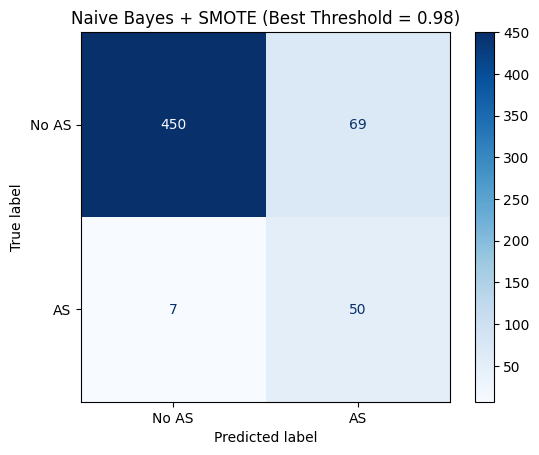

In [73]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------
# Naive Bayes + SMOTE pipeline
# ------------------------------
nb_pipeline = ImbPipeline(steps=[
    ('smote', SMOTE(random_state=42)),  # SMOTE FIRST
    ('nb', GaussianNB())                # no priors: let NB learn from resampled data
])

# Param grid: NB smoothing + SMOTE sampling strategy
nb_param_grid = {
    'nb__var_smoothing': np.logspace(-12, -6, 7),
    'smote__sampling_strategy': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
beta2_scorer, beta2_value = make_beta2_scorer(pos_label=1)

nb_grid = GridSearchCV(
    estimator=nb_pipeline,
    param_grid=nb_param_grid,
    cv=cv,
    scoring=beta2_scorer,      # Fβ on AS = 1
    n_jobs=-1,
    verbose=1
)

# Fit on TRAIN ONLY (SMOTE happens inside CV folds)
nb_grid.fit(X_train, y_train)

print("Best Parameters (Naive Bayes + SMOTE):", nb_grid.best_params_)
print(f"Best CV F{beta2_value} (Naive Bayes + SMOTE):     {nb_grid.best_score_:.4f}")

best_nb_smote = nb_grid.best_estimator_
y_proba_nb = best_nb_smote.predict_proba(X_test)[:, 1]

best_threshold_nb, best_fbeta_nb, thr_array_nb, fbeta_array_nb = find_best_threshold_fbeta(
    y_true=y_test,
    y_proba=y_proba_nb,
    beta=beta2_value,
    pos_label=1,
    thresholds=np.arange(0.25, 1.01, 0.01)
)

print(f"\nBest threshold for Naive Bayes + SMOTE (F{beta2_value}): {best_threshold_nb:.2f}")
print(f"Best F{beta2_value} at that threshold: {best_fbeta_nb:.4f}")

y_pred_nb_best = (y_proba_nb >= best_threshold_nb).astype(int)

print("\nClassification Report at Best Threshold:\n")
print(classification_report(y_test, y_pred_nb_best, target_names=['No AS', 'AS']))

print("\nConfusion Matrix at Best Threshold:")
cm_nb_best = confusion_matrix(y_test, y_pred_nb_best)
print(cm_nb_best)

disp = ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred_nb_best,
    display_labels=['No AS', 'AS'],
    cmap='Blues'
)
plt.title(f"Naive Bayes + SMOTE (Best Threshold = {best_threshold_nb:.2f})")
print(f'Best Naive Bayes + SMOTE BETA2 {beta2_value} Score: {nb_grid.best_score_:.4f}')

plt.show()

# AdaBoost

**Two models to include:**

**1. AdaBoost Benchmark**<br>
f1 = 0.61<br>
recall = 0.53

**2. AdaBoost with Tuning**<br>
Best threshold for F1: 0.47<br>
f1 = 0.64<br>
recall = 0.72

## AdaBoost Benchmark


=== AdaBoost Benchmark – Classification Report ===

              precision    recall  f1-score   support

       No AS       0.95      0.98      0.96       519
          AS       0.75      0.53      0.62        57

    accuracy                           0.94       576
   macro avg       0.85      0.75      0.79       576
weighted avg       0.93      0.94      0.93       576


=== AdaBoost Benchmark – Confusion Matrix ===

[[509  10]
 [ 27  30]]


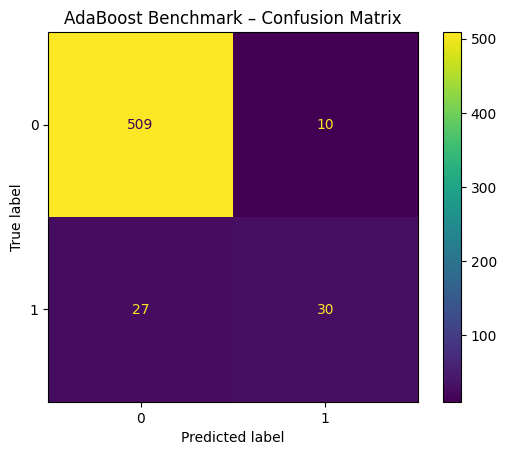

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

# Baseline AdaBoost model
adaboost_benchmark = AdaBoostClassifier(random_state=42)
adaboost_benchmark.fit(X_train, y_train)

# Predictions
y_pred_ada = adaboost_benchmark.predict(X_test)

print("\n=== AdaBoost Benchmark – Classification Report ===\n")
print(classification_report(y_test, y_pred_ada, target_names=['No AS','AS']))

print("\n=== AdaBoost Benchmark – Confusion Matrix ===\n")
print(confusion_matrix(y_test, y_pred_ada))

ConfusionMatrixDisplay.from_estimator(adaboost_benchmark, X_test, y_test)
plt.title("AdaBoost Benchmark – Confusion Matrix")
plt.show()

## AdaBoost with Tuning

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best AdaBoost Parameters: {'ada__estimator': DecisionTreeClassifier(max_depth=1, random_state=42), 'ada__learning_rate': 1.0, 'ada__n_estimators': 50}
Best AdaBoost CV F1.224744871391589 Score: 0.5401

Best threshold for AdaBoost (F1.224744871391589): 0.45
Best F1.224744871391589 at that threshold: 0.6122

Classification Report at Best Threshold:

              precision    recall  f1-score   support

       No AS       0.97      0.92      0.94       519
          AS       0.49      0.74      0.59        57

    accuracy                           0.90       576
   macro avg       0.73      0.83      0.76       576
weighted avg       0.92      0.90      0.91       576


Confusion Matrix at Best Threshold:
[[475  44]
 [ 15  42]]
Best AdaBoost BETA2 1.224744871391589 Score: 0.5401


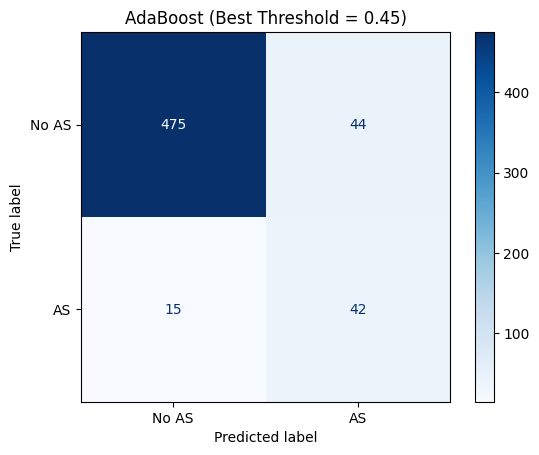

In [ ]:
# Pipeline: (optional scaler) + AdaBoost
ada_pipeline = SkPipeline(steps=[
    ('scaler', StandardScaler()),   # won't hurt, even if trees don't need it
    ('ada', AdaBoostClassifier(
        random_state=42
    ))
])

# Hyperparameter grid
ada_param_grid = {
    'ada__n_estimators': [50, 100, 200, 300],
    'ada__learning_rate': [0.01, 0.05, 0.1, 0.5, 1.0],
    'ada__estimator': [
        DecisionTreeClassifier(max_depth=1, random_state=42),
        DecisionTreeClassifier(max_depth=2, random_state=42)
    ]
}

# CV setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
beta2_scorer, beta2_value = make_beta2_scorer(pos_label=1)

# Grid search with F-beta
ada_grid = GridSearchCV(
    estimator=ada_pipeline,
    param_grid=ada_param_grid,
    cv=cv,
    scoring=beta2_scorer,      # Fβ, AS = positive
    n_jobs=-1,
    verbose=1
)

# Fit on training data
ada_grid.fit(X_train, y_train)

print("Best AdaBoost Parameters:", ada_grid.best_params_)
print(f"Best AdaBoost CV F{beta2_value} Score: {ada_grid.best_score_:.4f}")

# Best tuned model
best_ada = ada_grid.best_estimator_
y_proba_ada = best_ada.predict_proba(X_test)[:, 1]
best_t_ada, best_fbeta_ada, thr_array_ada, fbeta_array_ada = find_best_threshold_fbeta(
    y_true=y_test,
    y_proba=y_proba_ada,
    beta=beta2_value,
    pos_label=1,
    thresholds=None
)

print(f"\nBest threshold for AdaBoost (F{beta2_value}): {best_t_ada:.2f}")
print(f"Best F{beta2_value} at that threshold: {best_fbeta_ada:.4f}")
y_pred_ada_best = (y_proba_ada >= best_t_ada).astype(int)

print("\nClassification Report at Best Threshold:\n")
print(classification_report(y_test, y_pred_ada_best, target_names=['No AS', 'AS']))

print("\nConfusion Matrix at Best Threshold:")
cm_ada_best = confusion_matrix(y_test, y_pred_ada_best)
print(cm_ada_best)

ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred_ada_best,
    display_labels=['No AS', 'AS'],
    cmap='Blues'
)
plt.title(f"AdaBoost (Best Threshold = {best_t_ada:.2f})")
print(f'Best AdaBoost BETA2 {beta2_value} Score: {ada_grid.best_score_:.4f}')

plt.show()

# ROC Curve

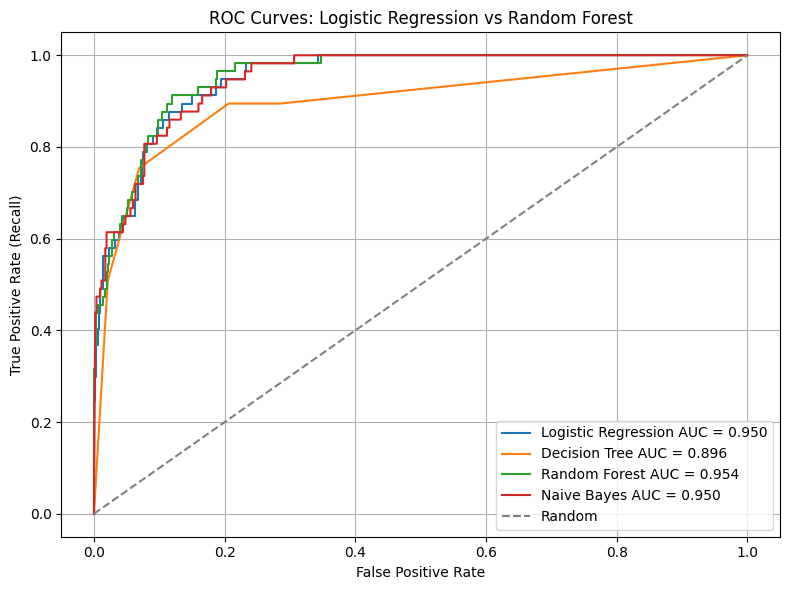

In [70]:
# ==== ROC CURVES FOR Random Forest + Logistic Regression ====
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# 1) Logistic Regression (best L1/L2 model)
# ------------------------------------------------------------
y_proba_logreg = best_model_opt_smote.predict_proba(X_test)[:, 1]
fpr_logreg, tpr_logreg, _ = roc_curve(y_test, y_proba_logreg)
auc_logreg = roc_auc_score(y_test, y_proba_logreg)

# ------------------------------------------------------------
# 2) Decision Tree (Post-Prune)
# ------------------------------------------------------------

y_proba_dectree = tree_post_model.predict_proba(X_test)[:, 1]
fpr_dectree, tpr_dectree, _ = roc_curve(y_test, y_proba_dectree)
auc_dectree = roc_auc_score(y_test, y_proba_dectree)

# ------------------------------------------------------------
# 3) Random Forest (best model from GridSearchCV)
# ------------------------------------------------------------
y_proba_rf = best_rf.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
auc_rf = roc_auc_score(y_test, y_proba_rf)

# ------------------------------------------------------------
# 3) Naive Bayes (SMOTE + Optimal Ratio)
# ------------------------------------------------------------
y_proba_nb = best_nb_smote.predict_proba(X_test)[:, 1]
fpr_nb, tpr_nb, _ = roc_curve(y_test, y_proba_nb)
auc_nb = roc_auc_score(y_test, y_proba_nb)

# ------------------------------------------------------------
# Plot ROC curves
# ------------------------------------------------------------
plt.figure(figsize=(8, 6))

plt.plot(fpr_logreg, tpr_logreg, label=f'Logistic Regression AUC = {auc_logreg:.3f}')
plt.plot(fpr_dectree, tpr_dectree, label=f'Decision Tree AUC = {auc_dectree:.3f}')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest AUC = {auc_rf:.3f}')
plt.plot(fpr_nb, tpr_nb, label=f'Naive Bayes AUC = {auc_nb:.3f}')

# Random baseline
plt.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Random')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curves: Logistic Regression vs Random Forest')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


# PR Curve

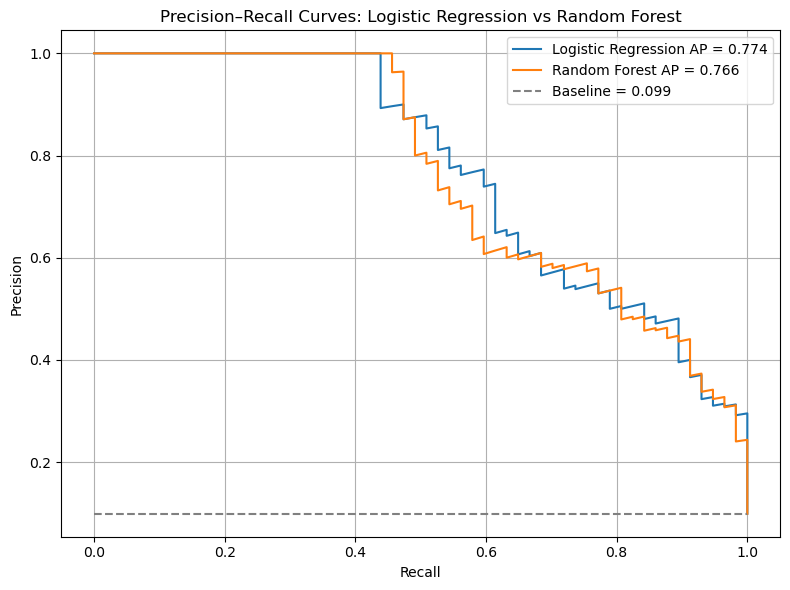

In [ ]:
# ==== PRECISION–RECALL CURVES FOR Logistic Regression + Random Forest ====
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# 1) Logistic Regression (best L1/L2 model)
# ------------------------------------------------------------
# If you already have y_proba_logreg from ROC code, you can reuse it.
# Otherwise, recompute:
y_proba_logreg = best_model_l1l2.predict_proba(X_test)[:, 1]

prec_logreg, rec_logreg, _ = precision_recall_curve(y_test, y_proba_logreg)
ap_logreg = average_precision_score(y_test, y_proba_logreg)

# ------------------------------------------------------------
# 2) Random Forest (best model from GridSearchCV)
# ------------------------------------------------------------
best_rf = grid_rf.best_estimator_
y_proba_rf = best_rf.predict_proba(X_test)[:, 1]

prec_rf, rec_rf, _ = precision_recall_curve(y_test, y_proba_rf)
ap_rf = average_precision_score(y_test, y_proba_rf)

# ------------------------------------------------------------
# Plot PR curves
# ------------------------------------------------------------
plt.figure(figsize=(8, 6))

plt.plot(rec_logreg, prec_logreg, label=f'Logistic Regression AP = {ap_logreg:.3f}')
plt.plot(rec_rf, prec_rf, label=f'Random Forest AP = {ap_rf:.3f}')

# Baseline: horizontal line at prevalence of positive class
pos_rate = y_test.mean()
plt.hlines(pos_rate, 0, 1, colors='grey', linestyles='--', label=f'Baseline = {pos_rate:.3f}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curves: Logistic Regression vs Random Forest')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
target_corr = df.corr(numeric_only=True)['AS'].sort_values(ascending=False)
print(target_corr)


AS       1.000000
WAR      0.534536
TB       0.509234
HR       0.505596
IBB      0.504373
R        0.499594
RBI      0.494235
H        0.466220
OPS+     0.446580
OPS      0.442843
Rbat+    0.430529
rOBA     0.427806
SLG      0.427698
2B       0.419369
PA       0.413227
BB       0.408775
AB       0.402799
OBP      0.373060
BA       0.350818
G        0.338630
SO       0.278738
GIDP     0.270301
SF       0.237228
HBP      0.204578
SB       0.179593
3B       0.167110
CS       0.144826
Age      0.020578
SH      -0.096606
Name: AS, dtype: float64


In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif

selector = SelectKBest(score_func=f_classif, k=10)
selector.fit(X, y)

feature_scores = pd.DataFrame({
    'feature': X.columns,
    'score': selector.scores_
}).sort_values('score', ascending=False)

print(feature_scores)


   feature       score
1      WAR  767.255278
22      TB  671.508185
9       HR  658.667913
27     IBB  654.397650
5        R  637.949082
10     RBI  619.936500
6        H  532.684600
19    OPS+  477.804401
18     OPS  467.898026
21   Rbat+  436.399791
20    rOBA  429.664051
17     SLG  429.399265
7       2B  409.303311
3       PA  394.951638
13      BB  384.788853
4       AB  371.458076
16     OBP  310.091755
15      BA  269.183141
2        G  248.424146
14      SO  161.572672
23    GIDP  151.179367
26      SF  114.376412
24     HBP   83.779132
11      SB   63.924415
8       3B   55.100226
12      CS   41.091128
25      SH   18.068600
0      Age    0.812549


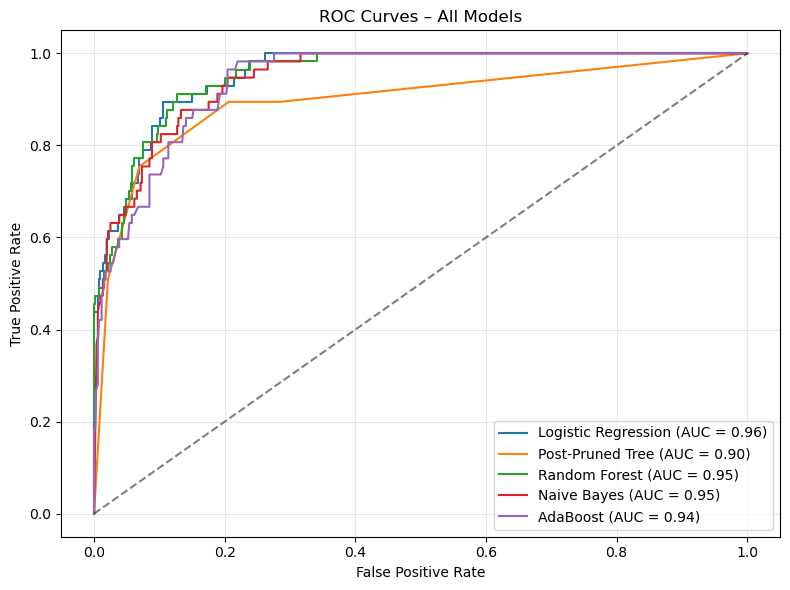

In [ ]:
model_probas = {
    "Logistic Regression": y_proba_test,
    "Post-Pruned Tree": y_proba_post,
    "Random Forest": y_proba_rf,
    "Naive Bayes": y_proba_nb,
    "AdaBoost": y_proba_ada
}
plt.figure(figsize=(8, 6))

for name, proba in model_probas.items():
    fpr, tpr, _ = roc_curve(y_test, proba)
    auc = roc_auc_score(y_test, proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.2f})")

# Diagonal reference line
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves – All Models")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

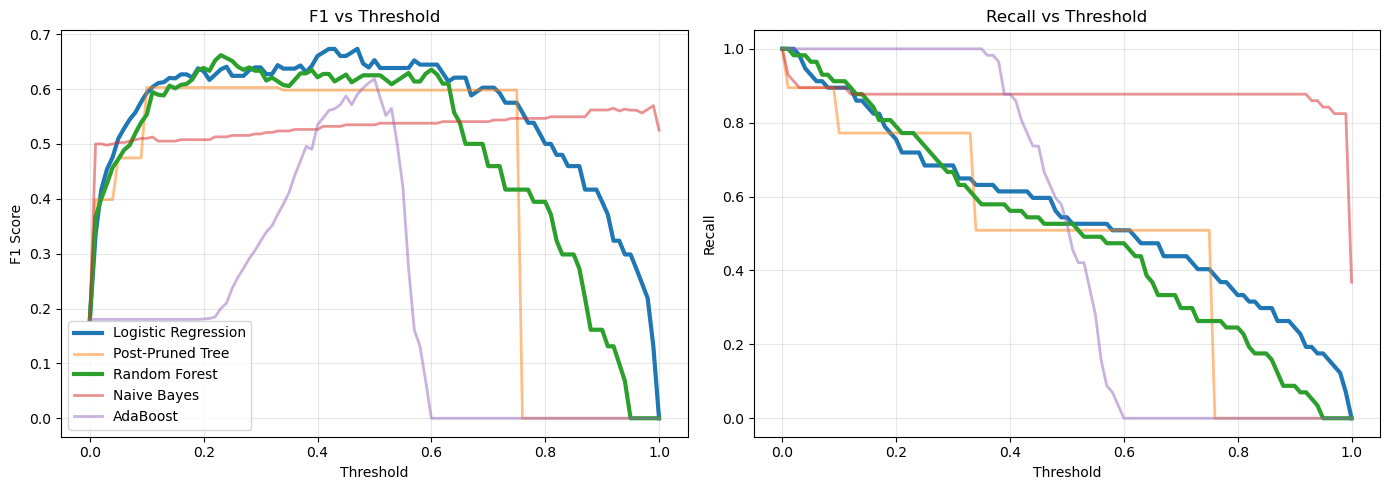

In [ ]:
from sklearn.metrics import f1_score, recall_score
import matplotlib.pyplot as plt
import numpy as np

thresholds = np.linspace(0.0, 1.0, 101)

highlight_models = ["Logistic Regression", "Random Forest"]

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharex=True)

for name, proba in model_probas.items():
    f1_vals = []
    rec_vals = []
    
    for t in thresholds:
        y_pred_t = (proba >= t).astype(int)
        f1_vals.append(f1_score(y_test, y_pred_t))
        rec_vals.append(recall_score(y_test, y_pred_t))
    
    # Highlight special models
    if name in highlight_models:
        lw = 3
        alpha = 1.0
    else:
        lw = 2
        alpha = 0.5

    axes[0].plot(thresholds, f1_vals, label=name, linewidth=lw, alpha=alpha)
    axes[1].plot(thresholds, rec_vals, label=name, linewidth=lw, alpha=alpha)

axes[0].set_title("F1 vs Threshold")
axes[0].set_xlabel("Threshold")
axes[0].set_ylabel("F1 Score")
axes[0].grid(alpha=0.3)

axes[1].set_title("Recall vs Threshold")
axes[1].set_xlabel("Threshold")
axes[1].set_ylabel("Recall")
axes[1].grid(alpha=0.3)

axes[0].legend(loc="best")
plt.tight_layout()
plt.show()


# 2026 Prediction

## Refit the best model with 2021-2024 data

In [ ]:
# ======================
# 1. Prepare Training Data
# ======================

feature_cols = ['WAR', 'G', 'PA', 'AB', 'R', 'H', '2B', '3B', 'HR',
               'RBI', 'SB', 'CS', 'BB', 'SO', 'BA', 'OBP', 'SLG', 'OPS',
               'TB', 'HBP', 'SH', 'SF', 'IBB']

X_full = df[feature_cols]
y_full = df['AS']

best_pred_model = best_model_opt_smote   # your chosen trained model
best_pred_model.fit(X_full, y_full) # refit on all labeled data

# ======================
# 2. Load 2026 Projection Data
# ======================

df_2026 = pd.read_excel(r"C:\Users\cpim1\Downloads\fangraphs-leaderboard-projections (1).xlsx", sheet_name='final') 

# make sure the dataset has all needed columns
X_2026 = df_2026[feature_cols] # remove any columns not in the training data

# ======================
# 3. Predict Probabilities + Predicted Class
# ======================

# probability of being All-Star (positive class = 1)
allstar_probs_2026 = best_pred_model.predict_proba(X_2026)[:, 1]

# binary prediction using default threshold 0.5.
allstar_pred_2026 = best_pred_model.predict(X_2026) 

# custom threshold
best_pred_threshold = 0.33
allstar_pred_2026_custom = (allstar_probs_2026 >= best_pred_threshold).astype(int)

# ======================
# 4. Prepare Results Table
# ======================

results_2026 = df_2026.copy()
results_2026['AS_prob'] = allstar_probs_2026
results_2026['AS_pred_default'] = allstar_pred_2026
results_2026['AS_pred_custom'] = allstar_pred_2026_custom

# keep only predicted All Stars based on the custom model
predicted_AS = (
    results_2026[results_2026['AS_pred_custom'] == 1]
        .sort_values('AS_prob', ascending=False)
)

# show name + probability
cols_to_show = ['Name', 'AS_prob']
predicted_AS = predicted_AS[cols_to_show]

predicted_AS.reset_index(drop = True, inplace = True)
predicted_AS

,Name,AS_prob
0,Aaron Judge,0.999819
1,Shohei Ohtani,0.992562
2,Yordan Alvarez,0.985605
3,Vladimir Guerrero Jr.,0.982964
4,José Ramírez,0.976648
5,Cal Raleigh,0.924767
6,Juan Soto,0.923202
7,Corey Seager,0.919219
8,Bobby Witt Jr.,0.889760
9,Freddie Freeman,0.882781


In [ ]:
predicted_AS.shape

(45, 2)

# For just two graphs

In [ ]:
# ADD AN INDEX
predicted_AS.reset_index(inplace = True)
predicted_AS.drop(columns='index',inplace=True)
predicted_AS[['Name', 'AS_prob']]
predicted_AS[:23]




,Name,AS_prob
0,Aaron Judge,0.999819
1,Shohei Ohtani,0.992562
2,Yordan Alvarez,0.985605
3,Vladimir Guerrero Jr.,0.982964
4,José Ramírez,0.976648
5,Cal Raleigh,0.924767
6,Juan Soto,0.923202
7,Corey Seager,0.919219
8,Bobby Witt Jr.,0.889760
9,Freddie Freeman,0.882781


In [ ]:
# ADD AN INDEX

predicted_AS[23:]

,Name,AS_prob
23,Matt Olson,0.599660
24,William Contreras,0.581765
25,Bo Bichette,0.578516
26,Mookie Betts,0.547794
27,Nick Kurtz,0.532805
28,Josh Naylor,0.512621
29,Brent Rooker,0.500144
30,Alex Bregman,0.499088
31,Cody Bellinger,0.490618
32,Vinnie Pasquantino,0.472697


# For 3 graphs of 15

In [ ]:
predicted_AS[:15]

,Name,AS_prob
0,Aaron Judge,0.999819
1,Shohei Ohtani,0.992562
2,Yordan Alvarez,0.985605
3,Vladimir Guerrero Jr.,0.982964
4,José Ramírez,0.976648
5,Cal Raleigh,0.924767
6,Juan Soto,0.923202
7,Corey Seager,0.919219
8,Bobby Witt Jr.,0.889760
9,Freddie Freeman,0.882781


In [ ]:
predicted_AS[15:30]

,Name,AS_prob
15,Bryce Harper,0.765791
16,Gunnar Henderson,0.735672
17,Fernando Tatis Jr.,0.730375
18,Yandy Díaz,0.700022
19,Pete Alonso,0.683680
20,Manny Machado,0.669665
21,Salvador Perez,0.615471
22,Kyle Tucker,0.612005
23,Matt Olson,0.599660
24,William Contreras,0.581765


In [ ]:
predicted_AS[30:45]

,Name,AS_prob
30,Alex Bregman,0.499088
31,Cody Bellinger,0.490618
32,Vinnie Pasquantino,0.472697
33,Francisco Lindor,0.469113
34,Elly De La Cruz,0.467058
35,Kyle Schwarber,0.453158
36,Austin Riley,0.431575
37,Jackson Merrill,0.431026
38,Jose Altuve,0.413034
39,Riley Greene,0.411896


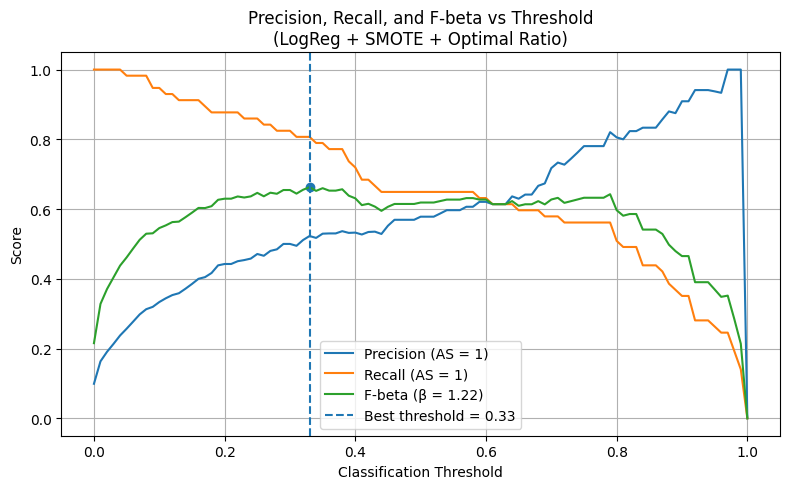

In [76]:
from sklearn.metrics import precision_score, recall_score, fbeta_score
import matplotlib.pyplot as plt
import numpy as np

# 8a. Threshold curve: Precision, Recall, F-beta vs Threshold
# ----------------------------------------------------------

# Use the same thresholds you passed into find_best_threshold_fbeta
thresholds = np.arange(0.0, 1.01, 0.01)

precisions = []
recalls = []
fbeta_scores = []

for t in thresholds:
    # Predicted labels at threshold t
    y_pred_t = (y_proba_test_smote_optimal >= t).astype(int)
    
    # Metrics for AS = 1 (All-Star class)
    p = precision_score(y_test, y_pred_t, pos_label=1, zero_division=0)
    r = recall_score(y_test, y_pred_t, pos_label=1, zero_division=0)
    f = fbeta_score(y_test, y_pred_t, beta=beta2_value, pos_label=1, zero_division=0)
    
    precisions.append(p)
    recalls.append(r)
    fbeta_scores.append(f)

plt.figure(figsize=(8, 5))
plt.plot(thresholds, precisions, label="Precision (AS = 1)")
plt.plot(thresholds, recalls, label="Recall (AS = 1)")
plt.plot(thresholds, fbeta_scores, label=f"F-beta (β = {beta2_value:.2f})")

# Highlight best threshold from your search
plt.axvline(x=best_threshold, linestyle="--", label=f"Best threshold = {best_threshold:.2f}")

# Optional: mark the point of best F-beta on the curve
plt.scatter([best_threshold], [best_fbeta], marker="o")

plt.xlabel("Classification Threshold")
plt.ylabel("Score")
plt.title("Precision, Recall, and F-beta vs Threshold\n(LogReg + SMOTE + Optimal Ratio)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


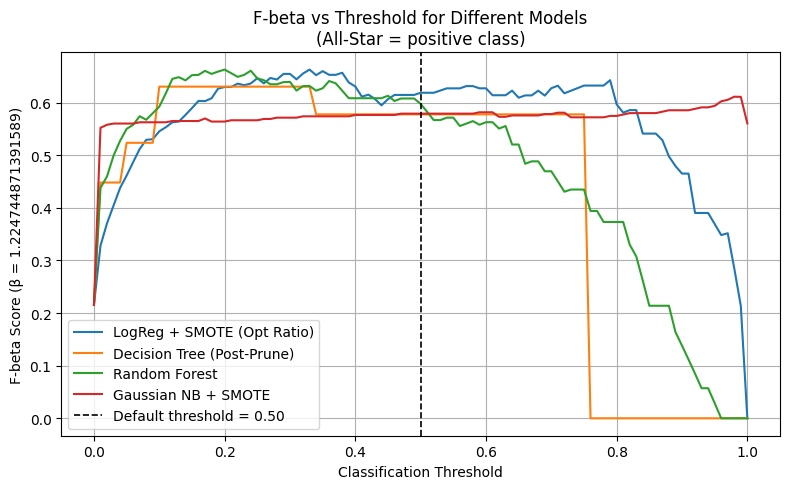

In [79]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import fbeta_score

# -------------------------------
# 1. Put your model probabilities here
# -------------------------------
# Probabilities for class 1 (All-Star)

models_proba = {
    "LogReg + SMOTE (Opt Ratio)": y_proba_test_smote_optimal,
    "Decision Tree (Post-Prune)": y_proba_post,
    "Random Forest":              y_proba_rf,
    "Gaussian NB + SMOTE":        y_proba_nb
}

beta = beta2_value  # e.g. 1.24

# Threshold grid
thresholds = np.arange(0.0, 1.01, 0.01)

plt.figure(figsize=(8, 5))

# -------------------------------
# 2. Compute F-beta vs threshold for each model
# -------------------------------
for model_name, y_proba in models_proba.items():
    fbeta_scores = []
    
    for t in thresholds:
        y_pred_t = (y_proba >= t).astype(int)
        f = fbeta_score(
            y_test,
            y_pred_t,
            beta=beta,
            pos_label=1,
            zero_division=0
        )
        fbeta_scores.append(f)
    
    plt.plot(thresholds, fbeta_scores, label=model_name)

# -------------------------------
# 3. Add reference line at default threshold = 0.50
# -------------------------------
plt.axvline(
    x=0.50,
    linestyle="--",
    color="black",
    linewidth=1.2,
    label="Default threshold = 0.50"
)

# -------------------------------
# 4. Formatting the plot
# -------------------------------
plt.xlabel("Classification Threshold")
plt.ylabel(f"F-beta Score (β = {beta})")
plt.title("F-beta vs Threshold for Different Models\n(All-Star = positive class)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
